<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 1 : Exploration </font>

**Librairies**

In [1]:
# Data analyse
import pandas as pd
import numpy as np
import re
from pprint import pprint
import string

In [2]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
# Preprocessing
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy # for lemmatization
nlp = spacy.load("en_core_web_md")

C:\Users\EliseAndro\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Chargement des données

In [5]:
df = pd.read_csv("Data/QueryResults.csv")

In [6]:
df

,Body,Title,Tags
0,<p>Is there any way to tinker with the iPhone ...,How can I develop for iPhone using a Windows d...,<ios><iphone><windows>
1,<p>I have this gigantic ugly string:</p>\n<pre...,My regex is matching too much. How do I make i...,<regex>
2,<p>I am Working with autolayout and constraint...,"What is ""Constrain to margin"" in Storyboard in...",<ios><xcode><storyboard><autolayout><xcode6>
3,<p>I'm learning objective-c and keep bumping i...,What does the @ symbol represent in objective-c?,<objective-c>
4,"<p>Is there a simple way, in a pretty standard...",Delete all but the most recent X files in bash,<bash><unix><scripting>
...,...,...,...
44990,"<p>Recently, I upgraded the version of Django ...",ImportError: cannot import name 'six' from 'dj...,<django>
44991,<p>How can I reject a promise that returned by...,How to reject in async/await syntax?,<javascript><asynchronous><typescript><es6-pro...
44992,<p>I have 2 entities that are related as one t...,.Net Core 3.0 possible object cycle was detect...,<c#><asp.net-core><entity-framework-core>
44993,<h2>Problem</h2>\n\n<p>I want to return a file...,Return file in ASP.Net Core Web API,<c#><asp.net-core><.net-core><asp.net-core-web...


# Preprocess et Analyse :  Body+Titre

## Nettoyage

**Liste de fonctions utiles pour le nettoyage et pre-processing**

In [7]:
# NLTK Stop words
stop_words = stopwords.words('english')
#stop_words.extend([liste de mots à retirer si besoin])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_non_alphabetical_character(text):
    """remove all non-alphabetical character"""
    text = re.sub("[^a-z]+", " ", text.lower()) # remove all non-alphabetical character
    text = re.sub("\s+", " ", text.lower()) # remove whitespaces left after the last operation
    return text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def word_count(text):
    return len(str(text).split(' '))

**Nettoyage**

In [8]:
# Nettoyage de la colonne Body
df['Body'] = [re.sub('<[^>]+>', '', i) for i in df['Body']]
df['Body'] = [re.sub('\n', '', i) for i in df['Body']]

df['Title'] = df['Title'].apply(lambda x: remove_non_alphabetical_character(x)) 
df['Body'] = df['Body'].apply(lambda x: remove_non_alphabetical_character(x)) 

# Nettoyage de la colonne Tags
tags_nettoye = [re.sub('><', ',', i)[1:-1] for i in df['Tags']]
df['Tags'] = tags_nettoye

df['content'] = df['Body'] + 3 * df['Title']
df = df[['content',"Tags"]]

In [9]:
data_words = list(sent_to_words(df['content'].values.tolist()))

print(data_words[:1])

[['is', 'there', 'any', 'way', 'to', 'tinker', 'with', 'the', 'iphone', 'sdk', 'on', 'windows', 'machine', 'are', 'there', 'plans', 'for', 'an', 'iphone', 'sdk', 'version', 'for', 'windows', 'the', 'only', 'other', 'way', 'can', 'think', 'of', 'doing', 'this', 'is', 'to', 'run', 'mac', 'vm', 'image', 'on', 'vmware', 'server', 'running', 'on', 'windows', 'although', 'not', 'too', 'sure', 'how', 'legal', 'this', 'is', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine']]


**Creating Bigram and Trigram Models**

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['is', 'there', 'any', 'way', 'to', 'tinker', 'with', 'the', 'iphone', 'sdk', 'on', 'windows', 'machine', 'are', 'there', 'plans', 'for', 'an', 'iphone', 'sdk', 'version', 'for', 'windows', 'the', 'only', 'other', 'way', 'can', 'think', 'of', 'doing', 'this', 'is', 'to', 'run', 'mac', 'vm', 'image', 'on', 'vmware', 'server', 'running', 'on', 'windows', 'although', 'not', 'too', 'sure', 'how', 'legal', 'this', 'is', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine']


**Stopwords, bigrams et lemmatization**

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
df['preprocess_content'] = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\ELISEA~1\AppData\Local\Temp/ipykernel_7992/4034995695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preprocess_content'] = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [12]:
df

,content,Tags,preprocess_content
0,is there any way to tinker with the iphone sdk...,"ios,iphone,windows","[way, machine, plan, version, way, think, run,..."
1,i have this gigantic ugly string j transaction...,regex,"[gigantic, ugly, string, transaction, start, p..."
2,i am working with autolayout and constraints a...,"ios,xcode,storyboard,autolayout,xcode6","[work, autolayout_constraint, find, constrain,..."
3,i m learning objective c and keep bumping into...,objective-c,"[learn, objective, keep, bump, symbol, use, di..."
4,is there a simple way in a pretty standard uni...,"bash,unix,scripting","[simple, way, pretty, standard, unix, environm..."
...,...,...,...
44990,recently i upgraded the version of django fram...,django,"[recently_upgrade, version, django, framework,..."
44991,how can i reject a promise that returned by an...,"javascript,asynchronous,typescript,es6-promise...","[reject, promise, return, async_await, functio..."
44992,i have entities that are related as one to man...,"c#,asp.net-core,entity-framework-core","[entity, relate, manypublic, class, restaurant..."
44993,problemi want to return a file in my asp net w...,"c#,asp.net-core,.net-core,asp.net-core-webapi","[want, return, file, web, api, controller, app..."


## Analyse descriptive

In [13]:
# Compte du nombre de mots
df['word_count'] = df['content'].apply(word_count)
df['word_count'].mean()

129.38284253805978

In [14]:
df['word_count'].describe()

count    44995.000000
mean       129.382843
std        129.374465
min         13.000000
25%         67.000000
50%         97.000000
75%        149.000000
max       4142.000000
Name: word_count, dtype: float64

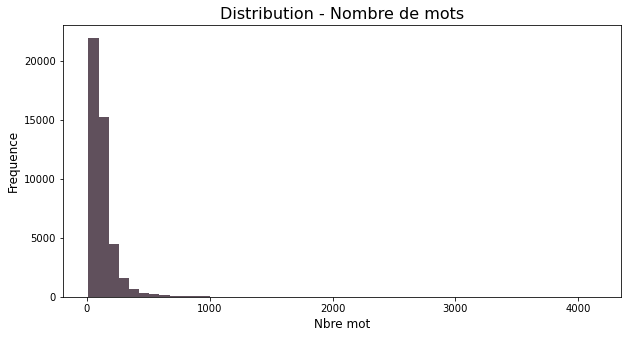

In [15]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=50,
    color='#60505C')

plt.title('Distribution - Nombre de mots', fontsize=16)
plt.ylabel('Frequence', fontsize=12)
plt.xlabel('Nbre mot', fontsize=12)

plt.show()

C:\Users\EliseAndro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\EliseAndro\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


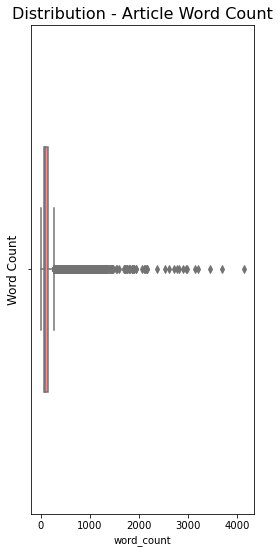

In [16]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    df['word_count'],
    orient='v',
    width=.5,
    color='#ff8080')

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
#plt.yticks(np.arange(0, 2700, 100))

plt.show()

In [17]:
# Get the top 20 most common words among all the articles
p_text = df['preprocess_content']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency'])

top_20

,word,frequency
0,use,48550
1,file,28296
2,get,21798
3,string,19873
4,error,16920
5,way,15804
6,class,15545
7,value,15441
8,code,14672
9,function,14570


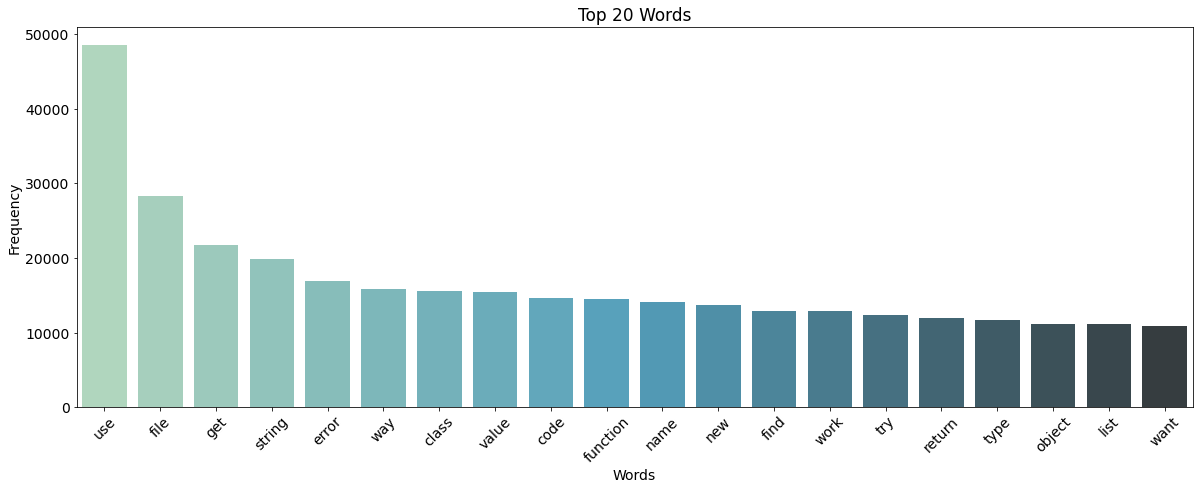

In [18]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d')

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [19]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

82363

# Preprocess et Analyse : Tags

## Tokenization des tags

In [20]:
df['Tags'] = [i.lower() for i in df['Tags']]
df['Tags'] = [i.split(",") for i in df['Tags']]

## Une colonne par tags

In [21]:
tags = []

for i in df['Tags']:
    tags = tags + i
    
tags = set(tags)
len(tags)

9474

In [22]:
for i in tags:
    df[i] = [1 if i in y else 0 for y in df['Tags']]

In [23]:
df.head()

,content,Tags,preprocess_content,word_count,executable,unity3d,optaplanner,spring-3,haxe,types,...,sessionstorage,bintray,clientid,mutation-events,dirname,beep,asp.net-optimization,stl-algorithm,if-statement,xjc
0,is there any way to tinker with the iphone sdk...,"[ios, iphone, windows]","[way, machine, plan, version, way, think, run,...",92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i have this gigantic ugly string j transaction...,[regex],"[gigantic, ugly, string, transaction, start, p...",144,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[ios, xcode, storyboard, autolayout, xcode6]","[work, autolayout_constraint, find, constrain,...",217,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,[objective-c],"[learn, objective, keep, bump, symbol, use, di...",64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[bash, unix, scripting]","[simple, way, pretty, standard, unix, environm...",131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Distribution des tags

histogramme du nbre d'individu par tags pour savoir si le tags est utile ou non (s'il n'a qu'un individu, sert à rien)

In [24]:
# Nbre d'occurence des tags
sum_column = df.iloc[:,4:].sum(axis=0)
print (sum_column.sort_values())

duplication       1
swingx            1
magento-1.9       1
jaas              1
yesod             1
               ... 
android        2863
c#             3281
java           4000
python         4683
javascript     4777
Length: 9474, dtype: int64


<AxesSubplot:>

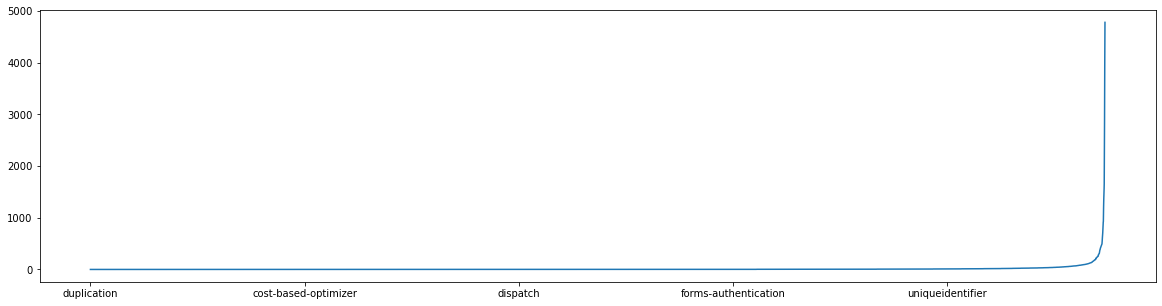

In [25]:
plt.figure(figsize=(20, 5))
sum_column.sort_values().plot()

On ne va garder que les 100 tags les plus utilisés

Text(0.5, 1.0, "Nombre d'occurence du tag")

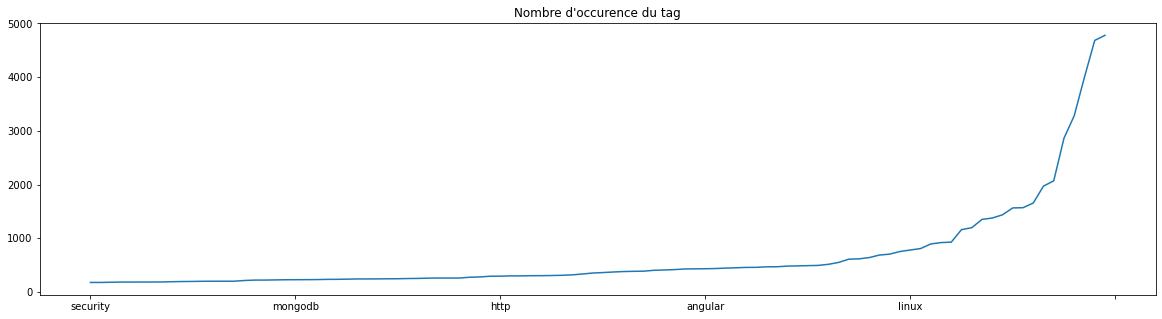

In [26]:
plt.figure(figsize=(20, 5))
sum_column.sort_values()[-100:].plot()
plt.title("Nombre d'occurence du tag")

In [27]:
df2 = df.drop(columns = sum_column.sort_values()[0:-100].index)
df2['nbre_tags'] = df2.iloc[:,4:].sum(axis=1)
df2.sort_values(by='nbre_tags')

# On retire tous les individus qui n'ont pas de tags parmi les 100 premiers 
df2 = df2.loc[df2['nbre_tags']>0]
df2.drop(columns = ['nbre_tags','Tags'], inplace=True)

In [28]:
# Nbre d'occurence des 100 premiers tags
sum_column2 = df2.iloc[:,4:-1].sum(axis=0)
print (sum_column2.sort_values())

security        178
java-8          178
forms           182
collections     185
class           185
               ... 
android        2863
c#             3281
java           4000
python         4683
javascript     4777
Length: 98, dtype: int64


In [29]:
# Regarde la différence de dataset, la perte des individus
print('df2 dimension:',df2.shape)
print('df dimension:',df.shape)

df2 dimension: (40774, 103)
df dimension: (44995, 9478)


In [30]:
df2.head()

,content,preprocess_content,word_count,r,numpy,gradle,scala,sorting,vim,python,...,file,asp.net-mvc,image,cocoa-touch,java-8,security,typescript,npm,macos,shell
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",92,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i have this gigantic ugly string j transaction...,"[gigantic, ugly, string, transaction, start, p...",144,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[work, autolayout_constraint, find, constrain,...",217,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",64,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",131,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Nombre de tags par individu

In [31]:
# Nbre de tags par individu sur df
sum_row = df.iloc[:,4:].sum(axis=1)
print (sum_row.sort_values())

11319    1
16311    1
5581     1
28853    1
5576     1
        ..
10772    5
10769    5
10767    5
34356    5
44994    5
Length: 44995, dtype: int64


Text(0.5, 1.0, 'Nombre de tags par individu')

<Figure size 1440x360 with 0 Axes>

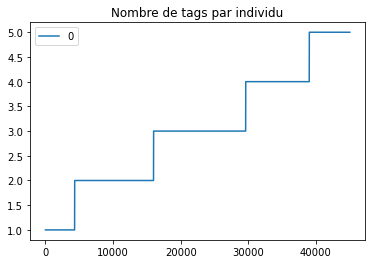

In [32]:
plt.figure(figsize=(20, 5))
sum_row.sort_values().reset_index().drop(columns ='index').plot()
plt.title("Nombre de tags par individu")

In [33]:
# Nbre de tags par individu sur df2
sum_row2 = df2.iloc[:,3:].sum(axis=1)
print (sum_row2.sort_values())

14439    1
18194    1
34833    1
18192    1
34834    1
        ..
26748    5
16726    5
30713    5
42989    5
19781    5
Length: 40774, dtype: int64


Text(0.5, 1.0, 'Nombre de tags par individu')

<Figure size 1440x360 with 0 Axes>

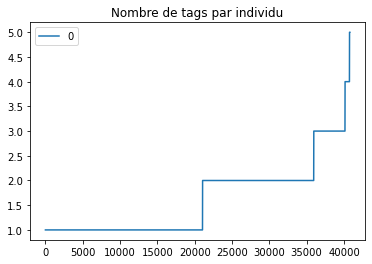

In [34]:
plt.figure(figsize=(20, 5))
sum_row2.sort_values().reset_index().drop(columns ='index').plot()
plt.title("Nombre de tags par individu")

# Export des datasets

In [35]:
df2.to_pickle("./preprocess_data.pkl")